In [1]:
# Preprocessing & results----------------
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, normalize
# nlp preprocessing
import spacy
# Models-------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process.kernels as kls
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
# for visualizing ---------------
import pydotplus
from sklearn import tree
from sklearn.externals.six import StringIO 
from IPython.display import Image, display
import seaborn as sns
# General purpose
import re
import pandas as pd
import pickle
import numpy as np
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.5/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
data_raw = pd.read_pickle('./features/all_data_features_17_20.pkl')
data_raw.head(2)

,cdate,content,ddate,details,forum,id,invitation,label,nonreaders,number,...,tmdate,writers,title,authors,abstract,keywords,tldr,ref_len,ref_latest,ref_years
2017_B1-Hhnslg,None,"{'conflicts': ['toronto.edu', 'twitter.com'], ...",None,{'replyCount': 9},B1-Hhnslg,2017_B1-Hhnslg,ICLR.cc/2017/conference/-/submission,Reject,[],581,...,1481060777491,[],Prototypical Networks for Few-shot Learning,"[Jake Snell, Kevin Swersky, Richard Zemel]",A recent approach to few-shot classification c...,"[Deep learning, Transfer Learning]",We learn a metric space in which few-shot clas...,26,2016,"[2013, 2015, 2013, 2009, 2016, 2004, 2014, 201..."
2017_B1-q5Pqxl,None,"{'conflicts': ['smu.edu.sg'], 'title': 'Machin...",None,{'replyCount': 18},B1-q5Pqxl,2017_B1-q5Pqxl,ICLR.cc/2017/conference/-/submission,Accept,[],417,...,1489370977828,[],Machine Comprehension Using Match-LSTM and Ans...,"[Shuohang Wang, Jing Jiang]",Machine comprehension of text is an important ...,"[Natural language processing, Deep learning]",Using Match-LSTM and Answer Pointer to select ...,24,2016,"[2015, 2016, 2016, 2016, 2016, 2015, 2016, 201..."


# Preprocessing

#### Contains ML keywords:

In [3]:
def ml_keywords_present(abstract):
    # collected from sense2vec spacy
    ml_keywords = ["outperforms", "outperform", "novel", "machine learning", "deep learning", "neural nets", "neural networks", "rnns", "rnn", "cnn", "cnns", "attention", "lstm", "adversarial network"]
    for keyw in ml_keywords:
        if abstract.lower().find(keyw) > -1:
            return 1
    return 0

#### Contains state-of-the-art

In [4]:
def sota_present(abstract):
    if abstract.lower().find('state-of-the-art') > -1 or abstract.lower().find('state of the art') > -1:
            return 1
    return 0

#### Glove vec average:

In [5]:
embeddings_dict = {}

with open("/home/shruti/data/glove/glove.6B/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [6]:
nlp = spacy.load("en_core_web_sm")

In [7]:
def get_glove_avg(abstract):
    glove_avg = 0
    count = 0
    
    doc = nlp(abstract)
    
    for tok in doc:
        if not tok.is_stop:
            clean_token = tok.text.lower().strip()
            if clean_token in embeddings_dict:
                count += 1
                glove_avg += embeddings_dict[clean_token]
    
    if count > 1:
        return np.mean(glove_avg/count)
    else:
        return np.mean(glove_avg)

#### Avg sentence length of abstract

In [8]:
def avg_abs_sent_length(abstract):
    avg_sent_length = 0
    
    doc = nlp(abstract)
    for s in doc.sents:
        avg_sent_length += len(s)
    
    num_sents = len(list(doc.sents))
    
    if num_sents > 0:
        return avg_sent_length/num_sents
    else:
        return avg_sent_length

#### Number of recent references (last 5 year)

In [9]:
def get_num_recent_refs(list_refs):
    count = 0
    for i in list_refs:
        if int(i) >= 2012:
            count += 1
    return count

#### Loading the new features dict

In [10]:
new_features_from_text = None
with open('./OCR_workspace/feature_dict/17_20_new_features.pkl', "rb") as f:
    new_features_from_text = pickle.load(f)

#### Loading the count of ICLR references featres dict

In [11]:
iclr_refs_count = None
with open('./OCR_workspace/feature_dict/iclr_refs_count.pkl', 'rb') as f:
    iclr_refs_count = pickle.load(f)

In [12]:
list(iclr_refs_count.items())[0:5]

[('2018_rk9kKMZ0-', 0),
 ('2018_rJ8rHkWRb', 0),
 ('2017_Syoiqwcxx', 3),
 ('2020_HkgR8erKwB', 0),
 ('2019_H1fU8iAqKX', 1)]

#### Avg. ref mention length in chars

In [13]:
def get_avg_ref_mention_length(id):
    pid = id
    if pid in new_features_from_text:
        if "avg_ref_mention" in new_features_from_text[pid]:
            return new_features_from_text[pid]["avg_ref_mention"]
        else:
            print("Missing avg_ref_mention for: ", pid)
            return 0
    else:
        print("Missing pid for ", pid)
        return 0

#### Number of sections

In [14]:
def get_num_sections(id):
    pid = id
    #pid = "2017" + "_" + id
    if pid in new_features_from_text:
        if "num_sections" in new_features_from_text[pid]:
            return new_features_from_text[pid]["num_sections"]
        else:
            return 4
    else:
        print("Missing pid for ", pid)
        return 4

#### Contains appendix

In [15]:
def contains_appendix(id):
    pid=id
    #pid = "2017" + "_" + id
    if pid in new_features_from_text:
        if "contains_appendix" in new_features_from_text[pid]:
            return new_features_from_text[pid]["contains_appendix"]
        else:
            print("Key contains_appendix not present: ", pid)
            return 0
    else:
        print("Missing pid for ", pid)
        return 0

#### Count of tables, equations, figures

In [16]:
def get_count_of_fig_table_eqn(id):
    pid=id
    #pid = "2017" + "_" + id
    if pid in new_features_from_text:
        if "table_ref_count" in new_features_from_text[pid] and "eqn_ref_count" in new_features_from_text[pid] and "fig_ref_count" in new_features_from_text[pid]:
            total_count = new_features_from_text[pid]["table_ref_count"] + new_features_from_text[pid]["fig_ref_count"] + new_features_from_text[pid]["eqn_ref_count"]
            return total_count
        else:
            print("Keys  count_of_fig_table_eqn keys missing for ", pid)
            return 0
    else:
        print("Missing pid for ", pid)
        return 0

#### contains table

In [17]:
def contains_table(id):
    pid = id
    
    if pid in new_features_from_text:
        if "table_ref_count" in new_features_from_text[pid] and new_features_from_text[pid]["table_ref_count"] and new_features_from_text[pid]["table_ref_count"]>0:
            return 1
    return 0

#### Contains equation(s)

In [18]:
def contains_equation(id):
    pid = id
    
    if pid in new_features_from_text:
        if "eqn_ref_count" in new_features_from_text[pid] and new_features_from_text[pid]["eqn_ref_count"] and new_features_from_text[pid]["eqn_ref_count"]>0:
            return 1
    return 0

#### Contains figure(s)

In [19]:
def contains_figure(id):
    pid = id
    
    if pid in new_features_from_text:
        if "fig_ref_count" in new_features_from_text[pid] and new_features_from_text[pid]["fig_ref_count"] and new_features_from_text[pid]["fig_ref_count"]>0:
            return 1
    return 0

#### Count of ICLR references

In [20]:
def get_iclr_refs_count(id):
    pid = id
    if pid in iclr_refs_count:
        return iclr_refs_count[pid]
    return 0

### Feature Matrix Creation

In [21]:
data = pd.DataFrame()
data_raw = data_raw[data_raw['label']!='Invite']
data['id'] = data_raw['id']
data['n_authors'] = data_raw['authors'].apply(len)
data['len_char_title'] = data_raw['title'].apply(len)
data['len_word_title'] = data_raw['title'].apply(lambda x: len(re.split(':|\s',x)))
data['len_char_abstract'] = data_raw['abstract'].apply(len)
data['len_word_abstract'] = data_raw['abstract'].apply(lambda x: len(re.split(':|\s',x)))
# data['replyCount'] = data_raw['replyCount']
data['n_keywords'] = data_raw['keywords'].apply(len)
data['ref_len'] = data_raw['ref_len']
data['ref_latest'] = data_raw['ref_latest']
data['num_recent_refs'] = data_raw['ref_years'].apply(get_num_recent_refs)
data['contains_ml_keyword'] = data_raw['abstract'].apply(ml_keywords_present)
data['avg_sent_len'] = data_raw['abstract'].apply(avg_abs_sent_length)
data['abs_glove_avg'] = data_raw['abstract'].apply(get_glove_avg)
data['contains_sota'] = data_raw['abstract'].apply(sota_present)
data['avg_ref_length'] = data_raw['id'].apply(get_avg_ref_mention_length)
data['num_sections'] = data_raw['id'].apply(get_num_sections)
data['contains_appendix'] = data_raw['id'].apply(contains_appendix)
data['fig_tab_eqn_count'] = data_raw['id'].apply(get_count_of_fig_table_eqn)
data['contains_table'] = data_raw['id'].apply(contains_table)
data['contains_figure'] = data_raw['id'].apply(contains_figure)
data['contains_equation'] = data_raw['id'].apply(contains_equation)
data['iclr_references'] = data_raw['id'].apply(get_iclr_refs_count)


data['label'] = data_raw['label']

Missing pid for  2018_H1cKvl-Rb
Missing pid for  2018_rJBwoM-Cb
Missing pid for  2019_S1giVsRcYm
Missing pid for  2020_SkeHuCVFDr
Missing pid for  2018_H1cKvl-Rb
Missing pid for  2018_rJBwoM-Cb
Missing pid for  2019_S1giVsRcYm
Missing pid for  2020_SkeHuCVFDr
Key contains_appendix not present:  2017_r1Usiwcex
Key contains_appendix not present:  2018_B1p461b0W
Key contains_appendix not present:  2018_By-7dz-AZ
Key contains_appendix not present:  2018_BywyFQlAW
Missing pid for  2018_H1cKvl-Rb
Key contains_appendix not present:  2018_HktXuGb0-
Missing pid for  2018_rJBwoM-Cb
Key contains_appendix not present:  2019_BJlc6iA5YX
Key contains_appendix not present:  2019_Byg0DsCqYQ
Key contains_appendix not present:  2019_Hyed4i05KX
Missing pid for  2019_S1giVsRcYm
Key contains_appendix not present:  2020_BJlxdCVKDB
Key contains_appendix not present:  2020_H1gx3kSKPS
Key contains_appendix not present:  2020_H1lQJ1HYwS
Key contains_appendix not present:  2020_HJgEMpVFwB
Missing pid for  2020_Sk

In [22]:
data.head(2)

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,num_recent_refs,...,contains_sota,avg_ref_length,num_sections,contains_appendix,fig_tab_eqn_count,contains_table,contains_figure,contains_equation,iclr_references,label
2017_B1-Hhnslg,2017_B1-Hhnslg,3,43,5,1062,156,2,26,2016,19,...,1,30,11,0,6,1,1,1,1,Reject
2017_B1-q5Pqxl,2017_B1-q5Pqxl,2,57,7,1145,173,2,24,2016,23,...,0,60,17,1,13,1,1,0,3,Accept


In [23]:
data[data.isnull().any(axis=1)]

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,num_recent_refs,...,contains_sota,avg_ref_length,num_sections,contains_appendix,fig_tab_eqn_count,contains_table,contains_figure,contains_equation,iclr_references,label


In [24]:
data['label'].unique()

array(['Reject', 'Accept'], dtype=object)

### Save feature dict for future experiments

In [27]:
data.to_pickle('./features/all_data_features_csv_17_20_new.pkl')

### Read data directly

In [ ]:
data = pd.read_pickle('./features/all_data_features_csv_17_20_new.pkl')
data.head(2)

### Running the Models

In [28]:
# shuffle the data
data = data.sample(n=len(data), random_state=42)

In [30]:
# To plot the Decision Tree--------------------------------------------
def plot(clf):
    dot_data = StringIO()
    tree.export_graphviz(clf[0], 
                         out_file=dot_data, 
                         class_names=['Accept','Reject'], # the target names.
                         feature_names=X.columns, # the feature names.
                         filled=True, # Whether to fill in the boxes with colours.
                         rounded=True, # Whether to round the corners of the boxes.
                         special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    return Image(graph.create_png())

#### All Models

In [31]:
clf_dict = {'DecisionTree':DecisionTreeClassifier(max_depth=3),
            'RandomForest':RandomForestClassifier(max_depth=10),
            'LogisticR':LogisticRegression(max_iter=5000),
            'LogisticLassoR':LogisticRegression(max_iter=5000, penalty='l1',solver='liblinear'),
            'RidgeClf':RidgeClassifier(max_iter=5000),
            'SVC':SVC(kernel='rbf'),
            'GaussNB':GaussianNB(),
            'NeuralNet':MLPClassifier((50),activation='logistic'),
            'KNN':KNeighborsClassifier(n_neighbors=10),
            'GaussianProcessClf':GaussianProcessClassifier(kernel=kls.RBF())
            }

#### A. Without Normalization

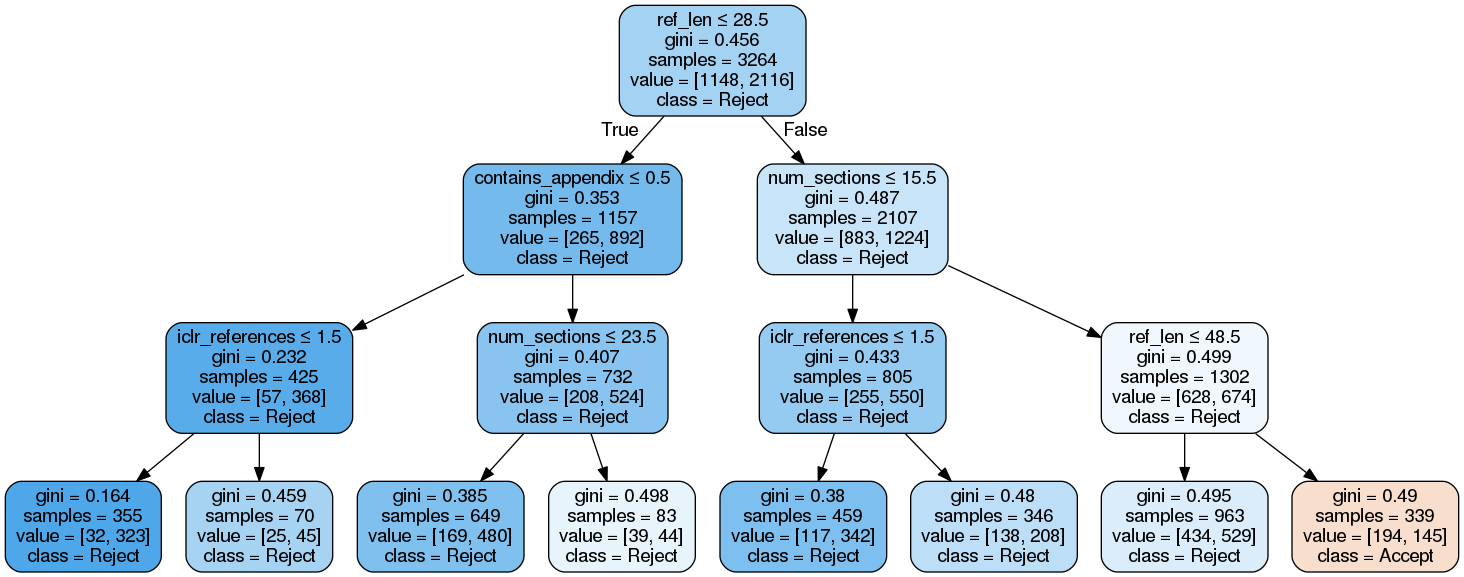

In [32]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
    X = data.drop(columns=['id','label'])
    y = data['label']
    results = cross_validate(clf, X, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == 'DecisionTree':
        display(plot(clf))

In [33]:
# Model results with all the new features without normalization
model_results

,Accuracy,CVresults
RandomForest,0.650192,"{'fit_time': [0.13768959045410156, 0.068237066..."
SVC,0.648152,"{'fit_time': [0.9058036804199219, 0.9056830406..."
DecisionTree,0.656932,"{'fit_time': [0.016857147216796875, 0.01682019..."
KNN,0.602818,"{'fit_time': [0.06288623809814453, 0.010370254..."
LogisticR,0.656322,"{'fit_time': [0.07733821868896484, 0.137030124..."
LogisticLassoR,0.658772,"{'fit_time': [0.3037564754486084, 0.5813546180..."
RidgeClf,0.658977,"{'fit_time': [0.15505385398864746, 0.051584243..."
GaussNB,0.635493,"{'fit_time': [0.020200014114379883, 0.01129031..."
GaussianProcessClf,0.535021,"{'fit_time': [11.783643245697021, 11.575909614..."
NeuralNet,0.642433,"{'fit_time': [2.0210280418395996, 3.4236779212..."


#### B. With Feature Normalization

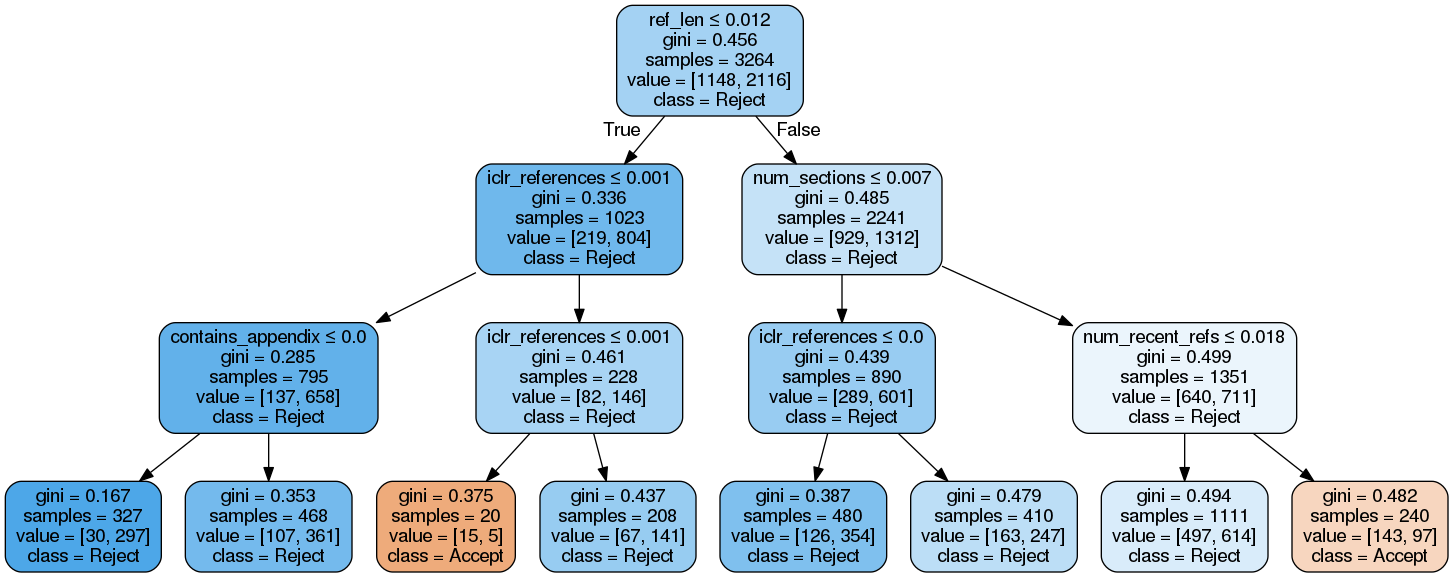

In [34]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
    X = data.drop(columns=['id', 'label'])
    y = data['label']
    X_normalized = normalize(X)
    results = cross_validate(clf, X_normalized, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == "DecisionTree":
        display(plot(clf))

In [35]:
# Model results with all the new features normalized
model_results

,Accuracy,CVresults
RandomForest,0.647131,"{'fit_time': [0.10721397399902344, 0.104953289..."
SVC,0.648152,"{'fit_time': [0.723097562789917, 0.76182937622..."
DecisionTree,0.650194,"{'fit_time': [0.029883384704589844, 0.02969646..."
KNN,0.603838,"{'fit_time': [0.008907556533813477, 0.00763273..."
LogisticR,0.648152,"{'fit_time': [0.013231277465820312, 0.03331446..."
LogisticLassoR,0.647131,"{'fit_time': [0.11252951622009277, 0.246364593..."
RidgeClf,0.647948,"{'fit_time': [0.07208609580993652, 0.034061193..."
GaussNB,0.494603,"{'fit_time': [0.016550064086914062, 0.01595687..."
GaussianProcessClf,0.653667,"{'fit_time': [103.16888380050659, 91.387792348..."
NeuralNet,0.647948,"{'fit_time': [5.900876998901367, 5.85564661026..."


In [47]:
model_results["CVresults"].iloc[8]

{'fit_time': array([103.1688838 ,  91.38779235, 100.46414757]),
 'score_time': array([0.34182882, 0.34286499, 0.33897281]),
 'test_score': array([0.64788732, 0.65073529, 0.66237745])}

#### C. 80-20 Train-Test Split with normalized features

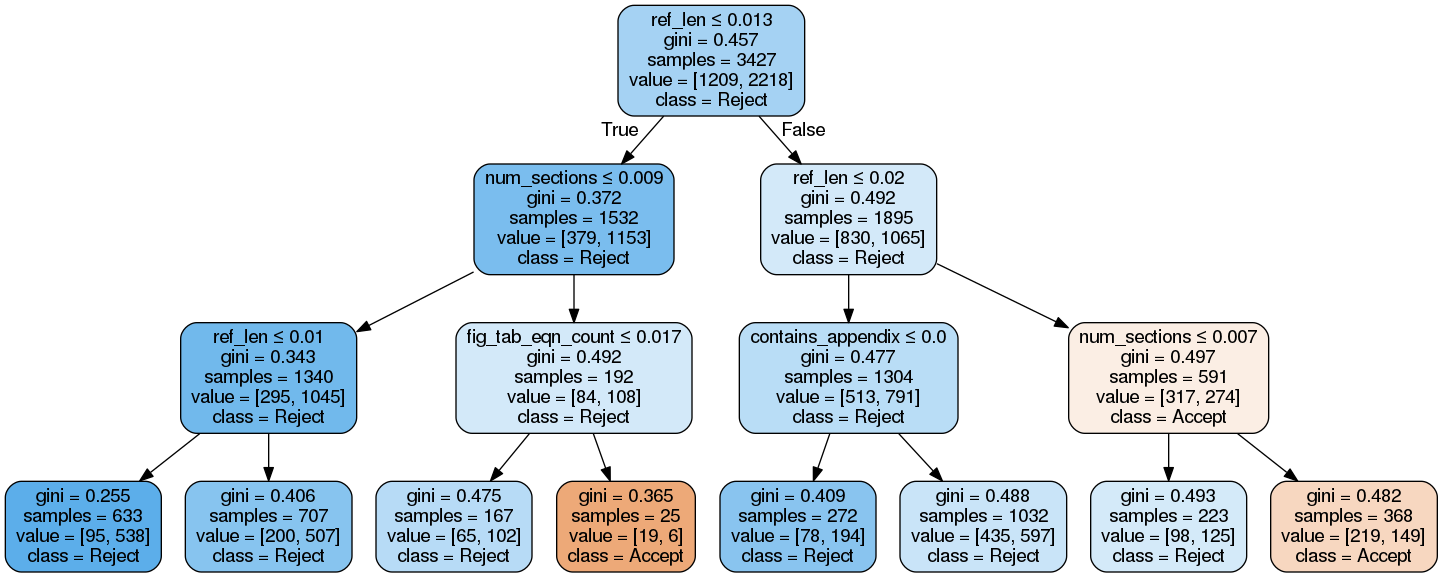

In [62]:
X = data.drop(columns=['id', 'label'])
y = data['label']
X_normalized = normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.30, random_state=42)

results_on_test = pd.DataFrame()
results_on_test['Accuracy'] = None

for clf_name,clf in clf_dict.items():
    clf.fit(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    results_on_test.loc[clf_name, 'Accuracy'] = test_score
    
    if clf_name == 'DecisionTree':
        display(plot([clf]))

In [63]:
# Model results on train-test with feature normalization
results_on_test

,Accuracy
RandomForest,0.648299
SVC,0.65034
DecisionTree,0.653061
KNN,0.62585
LogisticR,0.65034
LogisticLassoR,0.65034
RidgeClf,0.65034
GaussNB,0.42381
GaussianProcessClf,0.658503
NeuralNet,0.65034
